<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{simple-tensorflow} -->

# 🏋️‍♀️ W&B + 🌊 TensorFlow 2.x
Use Weights & Biases for machine learning experiment tracking, dataset versioning, and project collaboration.

<div><img /></div>

<img src="http://wandb.me/mini-diagram" width="650" alt="Weights & Biases" />

<div><img /></div>



<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/tensorflow/Simple_TensorFlow_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## What this notebook covers

* Easy integration of Weights and Biases with your TensorFlow pipeline for experiment tracking.
* Computing metrics with `keras.metrics`
* Using `wandb.log` to log those metrics in your custom training loop.
 

## The interactive W&B dashboard will look like this:


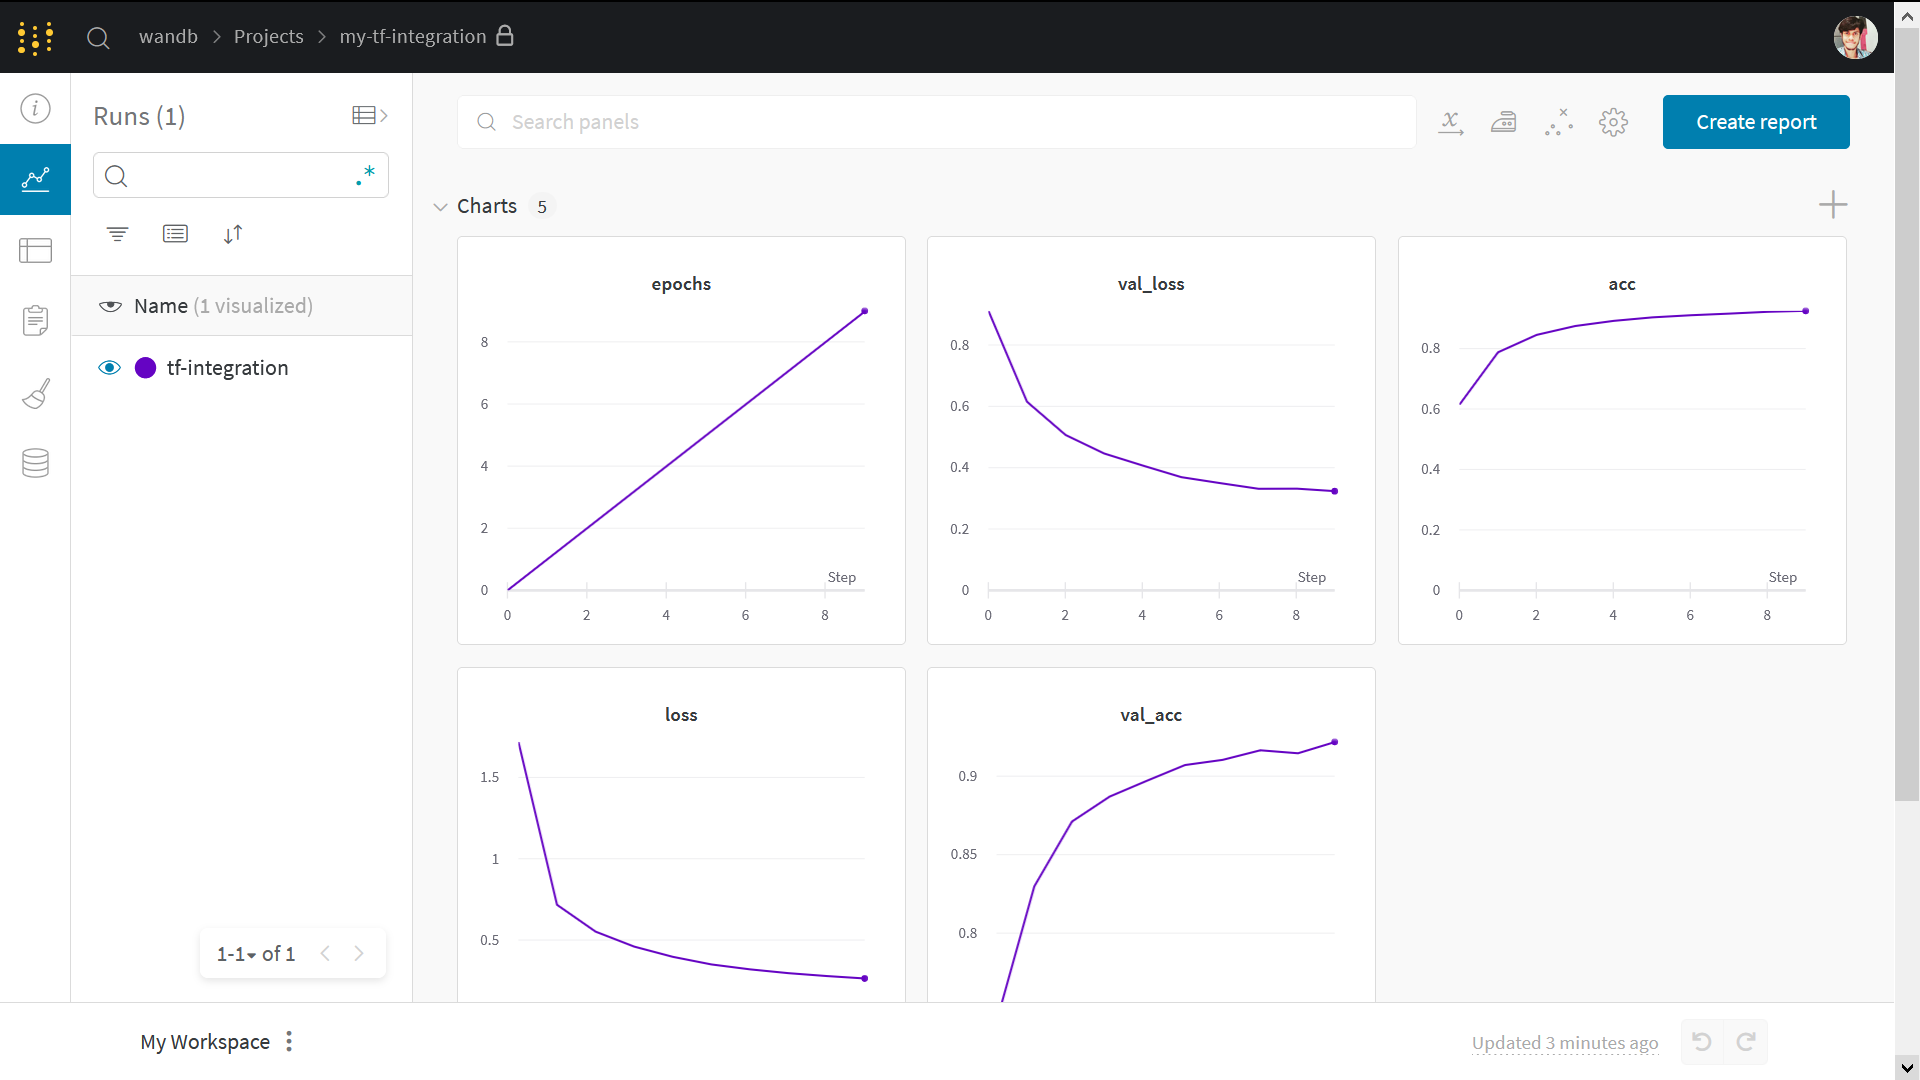


**Note**: Sections starting with _Step_ are all you need to integrate W&B into existing code. The rest is just a standard MNIST example.



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 🚀 Install, Import, Login

## Step 0️⃣: Install W&B

In [ ]:
%%capture
!pip install wandb

## Step 1️⃣: Import W&B and login

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

> Side note: If this is your first time using W&B or you are not logged in, the link that appears after running `wandb.login()` will take you to sign-up/login page. Signing up is as easy as one click.

# 👩‍🍳 Prepare Dataset

In [ ]:
# Prepare the training dataset
BATCH_SIZE = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# build input pipeline using tf.data
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
val_dataset = val_dataset.batch(BATCH_SIZE)

# 🧠 Define the Model and the Training Loop

In [ ]:
def make_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x1 = keras.layers.Dense(64, activation="relu")(inputs)
    x2 = keras.layers.Dense(64, activation="relu")(x1)
    outputs = keras.layers.Dense(10, name="predictions")(x2)

    return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y, logits)

    return loss_value

In [ ]:
def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

## Step 2️⃣: Add `wandb.log` to your training loop

In [ ]:
def train(train_dataset, val_dataset,  model, optimizer,
          train_acc_metric, val_acc_metric,
          epochs=10,  log_step=200, val_log_step=50):
  
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []   
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train, 
                                    model, optimizer, 
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val, 
                                       model, loss_fn, 
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))
            
        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # ⭐: log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc), 
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})

# 👟 Run Training

## Step 3️⃣: Call `wandb.init` to start a run

This lets us know you're launching an experiment,
so we can give it a unique ID and a dashboard.

[Check out the official documentation here $\rightarrow$](https://docs.wandb.com/library/init)


In [ ]:
# initialize wandb with your project name and optionally with configutations.
# play around with the config values and see the result on your wandb dashboard.
config = {
              "learning_rate": 0.001,
              "epochs": 10,
              "batch_size": 64,
              "log_step": 200,
              "val_log_step": 50,
              "architecture": "CNN",
              "dataset": "CIFAR-10"
           }

run = wandb.init(project='my-tf-integration', config=config)
config = wandb.config

# Initialize model.
model = make_model()

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=config.learning_rate)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

train(train_dataset,
      val_dataset, 
      model,
      optimizer,
      train_acc_metric,
      val_acc_metric,
      epochs=config.epochs, 
      log_step=config.log_step, 
      val_log_step=config.val_log_step)

run.finish()  # In Jupyter/Colab, let us know you're finished!

# 👀 Visualize Results

Click on the [**run page**](https://docs.wandb.ai/ref/app/pages/run-page)
link above to see your live results.

Or run the cell below to see an example dashboard rendered inside this notebook using [the `%wandb` magic](http://wandb.me/jupyter-interact-colab):

In [ ]:
%wandb charlesfrye/my-tf-integration/runs/1ru23zx2 -h 720 

# 🧹 Sweep 101

Use Weights & Biases Sweeps to automate hyperparameter optimization and explore the space of possible models.

## [Check out Hyperparameter Optimization in TensorFlow using W&B Sweeps $\rightarrow$](http://wandb.me/tf-sweeps-colab)

### Benefits of using W&B Sweeps

* **Quick setup**: With just a few lines of code you can run W&B sweeps.
* **Transparent**: We cite all the algorithms we're using, and [our code is open source](https://github.com/wandb/client/tree/master/wandb/sweeps).
* **Powerful**: Our sweeps are completely customizable and configurable. You can launch a sweep across dozens of machines, and it's just as easy as starting a sweep on your laptop.


<img src="https://i.imgur.com/6eWHZhg.png" alt="Sweep Result" />



# 🎨 Example Gallery

See examples of projects tracked and visualized with W&B in our gallery of examples, [Fully Connected →](https://wandb.me/fc)

# 📏 Best Practices
1. **Projects**: Log multiple runs to a project to compare them. `wandb.init(project="project-name")`
2. **Groups**: For multiple processes or cross validation folds, log each process as a runs and group them together. `wandb.init(group='experiment-1')`
3. **Tags**: Add tags to track your current baseline or production model.
4. **Notes**: Type notes in the table to track the changes between runs.
5. **Reports**: Take quick notes on progress to share with colleagues and make dashboards and snapshots of your ML projects.

## 🤓 Advanced Setup
1. [Environment variables](https://docs.wandb.com/library/environment-variables): Set API keys in environment variables so you can run training on a managed cluster.
2. [Offline mode](https://docs.wandb.com/library/technical-faq#can-i-run-wandb-offline): Use `dryrun` mode to train offline and sync results later.
3. [On-prem](https://docs.wandb.com/self-hosted): Install W&B in a private cloud or air-gapped servers in your own infrastructure. We have local installations for everyone from academics to enterprise teams.
4. [Artifacts](http://wandb.me/artifacts-colab): Track and version models and datasets in a streamlined way that automatically picks up your pipeline steps as you train models.